In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from scipy.stats import uniform, randint

def run_tuning_pipeline():
    """
    Loads data, creates advanced features, tunes an XGBoost model,
    and provides a detailed evaluation.
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_csv('train.csv')
        print("✅ Successfully loaded train.csv")
    except FileNotFoundError:
        print("❌ Error: 'train.csv' not found.")
        return

    # --- 2. Define Target ---
    TARGET_COLUMN = 'song_popularity'
    if TARGET_COLUMN not in df.columns:
        print(f"❌ Error: Target column '{TARGET_COLUMN}' not found.")
        return
        
    if 'id' in df.columns:
        df = df.drop('id', axis=1)

    # --- 3. Advanced Feature Engineering ---
    print("工程 Performing advanced feature engineering...")
    
    # Idea 1: Combine Key and Mode
    df['key_mode'] = df['key'].astype(str) + '_' + df['audio_mode'].astype(str)

    # Idea 2: Create Tempo Bins
    tempo_bins = [0, 90, 120, 150, df['tempo'].max()]
    tempo_labels = ['Slow', 'Medium', 'Fast', 'Very Fast']
    df['tempo_category'] = pd.cut(df['tempo'], bins=tempo_bins, labels=tempo_labels)
    
    # Idea 3: Interaction & Ratio Features
    df['danceability_energy'] = df['danceability'] * df['energy']
    df['energy_loudness_ratio'] = df['energy'] / (df['loudness'] - df['loudness'].min() + 1e-6)

    # Convert new categorical columns to 'category' dtype
    df['key_mode'] = df['key_mode'].astype('category')
    df['tempo_category'] = df['tempo_category'].astype('category')

    print("👍 New features created: 'key_mode', 'tempo_category', 'danceability_energy'.")

    # Define features (X) and target (y)
    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]

    # --- 4. Split Data ---
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )
    print(f"📊 Data split complete (60% train, 20% validation, 20% test).")

    # --- 5. Preprocessing Pipeline ---
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    # --- 6. Hyperparameter Tuning ---
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ])

    # Define the parameter distribution for Randomized Search
    param_dist = {
        'classifier__n_estimators': randint(100, 1000),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(3, 10),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree': uniform(0.6, 0.4)
    }

    print("\n⏳ Starting hyperparameter tuning with RandomizedSearchCV...")
    # Set up the search with 5-fold cross-validation
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter settings that are sampled
        cv=5,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,  # Use all available CPU cores
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print("✅ Tuning complete.")
    print(f"\n🏆 Best Parameters Found: {random_search.best_params_}")
    
    # The best model found by the search
    best_model = random_search.best_estimator_

    # --- 7. Final Evaluation on Validation Set ---
    y_val_pred = best_model.predict(X_val)
    y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

    # Calculate and print the validation accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)

    print("\n--- 🚀 Final Evaluation Scores (on Validation Set) ---")
    print(f"Accuracy:      {accuracy:.4f}")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

if __name__ == '__main__':
    run_tuning_pipeline()

✅ Successfully loaded train.csv
工程 Performing advanced feature engineering...
👍 New features created: 'key_mode', 'tempo_category', 'danceability_energy'.
📊 Data split complete (60% train, 20% validation, 20% test).

⏳ Starting hyperparameter tuning with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

✅ Successfully loaded train.csv
Engineering features...
👍 Feature engineering complete.
📊 Created 80/20 split for training and final hold-out validation.

⏳ Starting CV training on the 80% training set...
--- Fold 1/5 ---
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364427 -> initscore=-0.556200
[LightGBM] [Info] Start training from score -0.556200


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 2/5 ---
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364427 -> initscore=-0.556200
[LightGBM] [Info] Start training from score -0.556200


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 3/5 ---
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364427 -> initscore=-0.556200
[LightGBM] [Info] Start training from score -0.556200


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 4/5 ---
[LightGBM] [Info] Number of positive: 6997, number of negative: 12203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364427 -> initscore=-0.556200
[LightGBM] [Info] Start training from score -0.556200


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 5/5 ---
[LightGBM] [Info] Number of positive: 6996, number of negative: 12204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364375 -> initscore=-0.556425
[LightGBM] [Info] Start training from score -0.556425


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ All folds trained.

🚀 Averaging predictions and evaluating on the 20% hold-out set...

--- 🚀 Final ENSEMBLE Performance (on Hold-Out Set) ---
Accuracy:      0.5647
AUC-ROC Score: 0.5728

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      3814
           1       0.42      0.49      0.45      2186

    accuracy                           0.56      6000
   macro avg       0.55      0.55      0.54      6000
weighted avg       0.58      0.56      0.57      6000



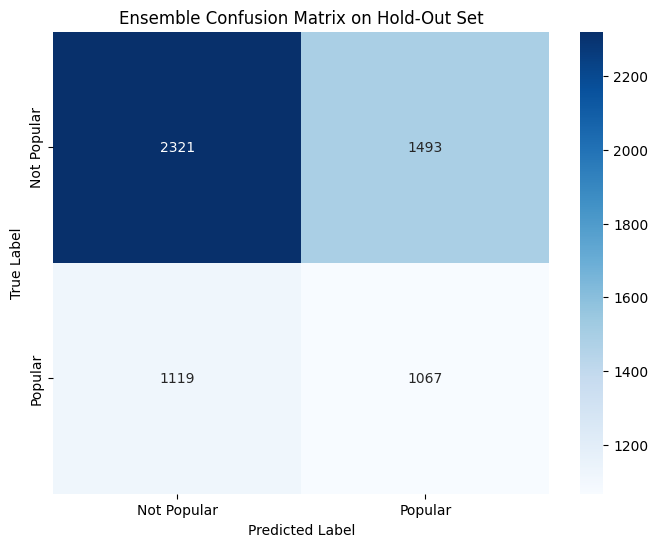

In [28]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix

def validate_ensemble_strategy():
    """
    Validates the cross-validation and averaging strategy on a hold-out set.
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_csv('train.csv')
        print("✅ Successfully loaded train.csv")
    except FileNotFoundError:
        print("❌ Error: 'train.csv' not found.")
        return

    TARGET_COLUMN = 'song_popularity'
    
    # --- 2. Feature Engineering (as a function) ---
    def engineer_features(df_in):
        df_out = df_in.copy()
        if 'id' in df_out.columns:
            df_out.drop('id', axis=1, inplace=True)
        df_out['key_mode'] = df_out['key'].astype(str) + '_' + df_out['audio_mode'].astype(str)
        df_out['tempo_category'] = pd.cut(df_out['tempo'], bins=[0, 90, 120, 150, 250], labels=['Slow', 'Medium', 'Fast', 'Very Fast'])
        df_out['loudness_scaled'] = (df_out['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
        df_out['party_index'] = df_out['danceability'] * df_out['energy'] * df_out['loudness_scaled']
        df_out['ballad_index'] = df_out['acousticness'] / (df_out['energy'] + 1e-6)
        df_out['vocal_focus'] = 1 - df_out['instrumentalness']
        df_out['studio_polish'] = 1 - df_out['liveness']
        df_out['rhythmic_vs_acoustic'] = df_out['danceability'] - df_out['acousticness']
        df_out['duration_log'] = np.log1p(df_out['song_duration_ms'])
        df_out['key_mode'] = df_out['key_mode'].astype('category')
        df_out['tempo_category'] = df_out['tempo_category'].astype('category')
        if 'loudness' in df_out.columns:
            df_out.drop(['loudness', 'song_duration_ms'], axis=1, inplace=True)
        return df_out

    print("Engineering features...")
    X_full = df.drop(TARGET_COLUMN, axis=1)
    y_full = df[TARGET_COLUMN]
    
    X_full = engineer_features(X_full)
    print("👍 Feature engineering complete.")

    # --- 3. Create a Hold-Out Validation Set ---
    # This splits the data into a main set for CV training (80%) and a hold-out set for final validation (20%)
    X_train_main, X_val_holdout, y_train_main, y_val_holdout = train_test_split(
        X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
    )
    print("📊 Created 80/20 split for training and final hold-out validation.")

    # --- 4. Preprocessing and Model Definition ---
    numerical_features = X_train_main.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X_train_main.select_dtypes(include=['category', 'object']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

    model = lgb.LGBMClassifier(
        colsample_bytree=0.662, learning_rate=0.0216, n_estimators=187,
        num_leaves=55, subsample=0.657,
        scale_pos_weight=1.74, random_state=42, n_jobs=-1
    )

    # --- 5. K-Fold Cross-Validation on the Main Training Set ---
    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    
    holdout_predictions = []
    print(f"\n⏳ Starting CV training on the 80% training set...")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_main, y_train_main)):
        print(f"--- Fold {fold+1}/{N_SPLITS} ---")
        X_train, y_train = X_train_main.iloc[train_idx], y_train_main.iloc[train_idx]
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        pipeline.fit(X_train, y_train)
        
        # Predict probabilities on the HOLD-OUT set
        fold_preds = pipeline.predict_proba(X_val_holdout)[:, 1]
        holdout_predictions.append(fold_preds)

    print("✅ All folds trained.")

    # --- 6. Evaluate the Averaged Predictions on the Hold-out Set ---
    print("\n🚀 Averaging predictions and evaluating on the 20% hold-out set...")
    final_holdout_proba = np.mean(holdout_predictions, axis=0)
    final_holdout_pred = (final_holdout_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_val_holdout, final_holdout_pred)
    roc_auc = roc_auc_score(y_val_holdout, final_holdout_proba)

    print("\n--- 🚀 Final ENSEMBLE Performance (on Hold-Out Set) ---")
    print(f"Accuracy:      {accuracy:.4f}")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val_holdout, final_holdout_pred))
    
    cm = confusion_matrix(y_val_holdout, final_holdout_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Popular', 'Popular'],
                yticklabels=['Not Popular', 'Popular'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Ensemble Confusion Matrix on Hold-Out Set')
    plt.show()

    return X_train_main, X_val_holdout, y_train_main, y_val_holdout



if __name__ == '__main__':
    X_train_main, X_val_holdout, y_train_main, y_val_holdout = validate_ensemble_strategy()


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import torch

def run_ultimate_ensemble_pipeline():
    # --- 1. Load & Split Data ---
    try:
        df = pd.read_csv('train.csv')
    except FileNotFoundError:
        print("❌ Error: 'train.csv' not found.")
        return
    
    TARGET_COLUMN = 'song_popularity'
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df[TARGET_COLUMN]
    )
    print(f"📊 Data split: {len(train_df)} training samples, {len(test_df)} hold-out test samples.")

    # --- 2. Feature Engineering ---
    def engineer_features(df_in):
        # (Using the same excellent feature engineering function)
        df_out = df_in.copy()
        if 'id' in df_out.columns:
            df_out.drop('id', axis=1, inplace=True)
        for col in df_out.select_dtypes(include=np.number).columns:
            df_out[col].fillna(df_out[col].median(), inplace=True)
        for col in df_out.select_dtypes(include=['object','category']).columns:
            df_out[col].fillna(df_out[col].mode()[0], inplace=True)
        df_out['key_mode'] = df_out['key'].astype(str) + '_' + df_out['audio_mode'].astype(str)
        df_out['tempo_category'] = pd.cut(df_out['tempo'], bins=[0,90,120,150,250], labels=['Slow','Medium','Fast','Very Fast'])
        df_out['loudness_scaled'] = (df_out['loudness'] - df_out['loudness'].min()) / (df_out['loudness'].max() - df_out['loudness'].min())
        df_out['party_index'] = df_out['danceability'] * df_out['energy'] * df_out['loudness_scaled']
        df_out['ballad_index'] = df_out['acousticness'] / (df_out['energy'] + 1e-6)
        df_out['vocal_focus'] = 1 - df_out['instrumentalness']
        df_out['studio_polish'] = 1 - df_out['liveness']
        df_out['rhythmic_vs_acoustic'] = df_out['danceability'] - df_out['acousticness']
        df_out['duration_log'] = np.log1p(df_out['song_duration_ms'])
        df_out['key_mode'] = df_out['key_mode'].astype('category')
        df_out['tempo_category'] = df_out['tempo_category'].astype('category')
        df_out.drop(['loudness','song_duration_ms', 'key', 'audio_mode', 'tempo'], axis=1, inplace=True)
        return df_out

    X_train = engineer_features(train_df.drop(TARGET_COLUMN, axis=1))
    y_train = train_df[TARGET_COLUMN]
    X_test = engineer_features(test_df.drop(TARGET_COLUMN, axis=1))
    y_test = test_df[TARGET_COLUMN]

    # --- 3. Preprocessing ---
    X_train_lgbm, X_test_lgbm = X_train.copy(), X_test.copy()
    
    categorical_features = X_train.select_dtypes(include=['category','object']).columns.tolist()
    numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

    for col in categorical_features:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        X_train_lgbm[col] = X_train_lgbm[col].astype('category')
        X_test_lgbm[col] = X_test_lgbm[col].astype('category')

    scaler = QuantileTransformer(output_distribution='normal', random_state=42)
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    
    cat_idxs = [X_train.columns.get_loc(col) for col in categorical_features]
    cat_dims = [X_train[col].nunique() for col in categorical_features]

    X_train_tabnet_np = X_train.values
    X_test_tabnet_np = X_test.values
    y_train_np = y_train.values
    y_test_np = y_test.values
    
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    print(f"Calculated scale_pos_weight for LightGBM: {scale_pos_weight:.2f}")


    # --- 4. K-Fold Cross-Validation for Both Models ---
    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    oof_preds_tabnet, test_preds_tabnet = np.zeros(len(X_train)), []
    oof_preds_lgbm, test_preds_lgbm = np.zeros(len(X_train)), []

    print(f"\n⏳ Starting {N_SPLITS}-Fold ULTIMATE Ensemble Training...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_np)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
        
        # --- TabNet Training ---
        print("Training TabNet...")
        tn_clf = TabNetClassifier(
            cat_idxs=cat_idxs, cat_dims=cat_dims, n_d=16, n_a=16, n_steps=4,
            gamma=1.5, lambda_sparse=1e-4,
            optimizer_fn=torch.optim.AdamW, optimizer_params=dict(lr=2e-2),
            scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
            scheduler_params={"mode": "max", "factor": 0.5, "patience": 5},
            mask_type='entmax', device_name='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=0
        )
        tn_clf.fit(
            X_train_tabnet_np[train_idx], y_train_np[train_idx],
            eval_set=[(X_train_tabnet_np[val_idx], y_train_np[val_idx])],
            patience=20, batch_size=1024, virtual_batch_size=256, weights=1, max_epochs=100
        )
        oof_preds_tabnet[val_idx] = tn_clf.predict_proba(X_train_tabnet_np[val_idx])[:, 1]
        test_preds_tabnet.append(tn_clf.predict_proba(X_test_tabnet_np)[:, 1])

        # --- YOUR Tuned LightGBM Training ---
        print("Training Your Tuned LightGBM...")
        lgbm_params = {
            'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
            'colsample_bytree': 0.662, 'learning_rate': 0.0216, 'n_estimators': 1000,
            'num_leaves': 55, 'subsample': 0.657, 'scale_pos_weight': scale_pos_weight,
            'random_state': 42, 'n_jobs': -1, 'verbose': -1
        }
        lgbm_clf = lgb.LGBMClassifier(**lgbm_params)
        lgbm_clf.fit(
            X_train_lgbm.iloc[train_idx], y_train.iloc[train_idx],
            eval_set=[(X_train_lgbm.iloc[val_idx], y_train.iloc[val_idx])],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )
        oof_preds_lgbm[val_idx] = lgbm_clf.predict_proba(X_train_lgbm.iloc[val_idx])[:, 1]
        test_preds_lgbm.append(lgbm_clf.predict_proba(X_test_lgbm)[:, 1])
        print("Fold complete.")

    # --- 5. Final Evaluation on Hold-Out Set ---
    final_test_preds_tabnet = np.mean(test_preds_tabnet, axis=0)
    final_test_preds_lgbm = np.mean(test_preds_lgbm, axis=0)
    final_test_preds_ensemble = (final_test_preds_tabnet + final_test_preds_lgbm) / 2
    
    print("\n\n" + "="*60)
    print("--- 🏆 FINAL MODEL PERFORMANCE (on 20% Hold-Out Test Set) 🏆 ---")
    print("="*60)

    acc_tabnet = accuracy_score(y_test_np, (final_test_preds_tabnet > 0.5).astype(int))
    acc_lgbm = accuracy_score(y_test_np, (final_test_preds_lgbm > 0.5).astype(int))
    acc_ensemble = accuracy_score(y_test_np, (final_test_preds_ensemble > 0.5).astype(int))
    
    auc_tabnet = roc_auc_score(y_test_np, final_test_preds_tabnet)
    auc_lgbm = roc_auc_score(y_test_np, final_test_preds_lgbm)
    auc_ensemble = roc_auc_score(y_test_np, final_test_preds_ensemble)

    print(f"TabNet Alone             | Accuracy: {acc_tabnet:.4f} | AUC: {auc_tabnet:.4f}")
    print(f"Your Tuned LightGBM Alone| Accuracy: {acc_lgbm:.4f} | AUC: {auc_lgbm:.4f}")
    print(f"ULTIMATE ENSEMBLE        | Accuracy: {acc_ensemble:.4f} | AUC: {auc_ensemble:.4f}")

    print("\n--- Final Ensemble Classification Report ---")
    print(classification_report(y_test_np, (final_test_preds_ensemble > 0.5).astype(int)))

if __name__ == '__main__':
    run_ultimate_ensemble_pipeline()

📊 Data split: 24000 training samples, 6000 hold-out test samples.


C:\Users\Harsh\AppData\Local\Temp\ipykernel_1456\3290011956.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_out[col].fillna(df_out[col].median(), inplace=True)
C:\Users\Harsh\AppData\Local\Temp\ipykernel_1456\3290011956.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

Calculated scale_pos_weight for LightGBM: 1.74

⏳ Starting 5-Fold ULTIMATE Ensemble Training...

--- Fold 1/5 ---
Training TabNet...

Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_0_auc = 0.54739


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Your Tuned LightGBM...
Fold complete.

--- Fold 2/5 ---
Training TabNet...

Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_0_auc = 0.56332


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Your Tuned LightGBM...
Fold complete.

--- Fold 3/5 ---
Training TabNet...

Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_auc = 0.55046


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Your Tuned LightGBM...
Fold complete.

--- Fold 4/5 ---
Training TabNet...

Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_auc = 0.57184


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Your Tuned LightGBM...
Fold complete.

--- Fold 5/5 ---
Training TabNet...

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_auc = 0.55134


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training Your Tuned LightGBM...
Fold complete.


--- 🏆 FINAL MODEL PERFORMANCE (on 20% Hold-Out Test Set) 🏆 ---
TabNet Alone             | Accuracy: 0.5193 | AUC: 0.5610
Your Tuned LightGBM Alone| Accuracy: 0.6333 | AUC: 0.5701
ULTIMATE ENSEMBLE        | Accuracy: 0.5880 | AUC: 0.5684

--- Final Ensemble Classification Report ---
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      3814
           1       0.42      0.32      0.36      2186

    accuracy                           0.59      6000
   macro avg       0.54      0.53      0.53      6000
weighted avg       0.57      0.59      0.57      6000



C:\Users\Harsh\AppData\Local\Temp\ipykernel_22280\3394764357.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_out[col].fillna(df_out[col].median(), inplace=True)
C:\Users\Harsh\AppData\Local\Temp\ipykernel_22280\3394764357.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


👍 Data prep complete.

⏳ Generating Level 0 predictions...
--- Fold 1/5 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Fold 2/5 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Fold 3/5 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Fold 4/5 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Fold 5/5 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Level 0 predictions generated.

⏳ Training Level 1 meta-model (The Manager)...
✅ Meta-model trained.

🚀 Evaluating the final stacking ensemble...

--- 🚀 Final Stacking Performance (Corrected) ---
Accuracy:       0.5428
AUC-ROC Score:  0.5700

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.52      0.59      3814
           1       0.41      0.59      0.48      2186

    accuracy                           0.54      6000
   macro avg       0.55      0.55      0.54      6000
weighted avg       0.59      0.54      0.55      6000



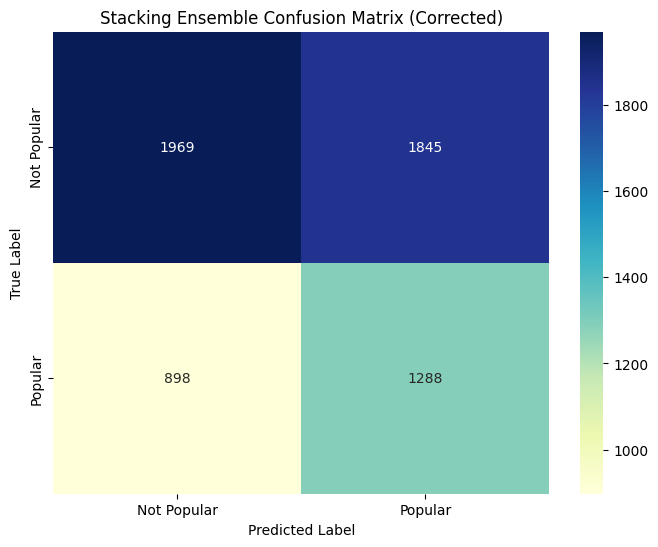

In [55]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def run_final_stacking_pipeline():
    """
    Combines the best LGBM and XGB models in a stacking ensemble,
    with a balanced meta-model.
    """
    # --- 1. Load Data & Create Splits ---
    try:
        df = pd.read_csv('train.csv')
    except FileNotFoundError:
        print("❌ Error: 'train.csv' not found.")
        return
    TARGET_COLUMN = 'song_popularity'
    
    def engineer_features(df_in):
        df_out = df_in.copy()
        if 'id' in df_out.columns: df_out.drop('id', axis=1, inplace=True)
        for col in df_out.select_dtypes(include=np.number).columns:
            df_out[col].fillna(df_out[col].median(), inplace=True)
        for col in df_out.select_dtypes(include=['object','category']).columns:
            df_out[col].fillna(df_out[col].mode()[0], inplace=True)
        df_out['key_mode'] = df_out['key'].astype(str) + '_' + df_out['audio_mode'].astype(str)
        df_out['tempo_category'] = pd.cut(df_out['tempo'], bins=[0, 90, 120, 150, 250], labels=['Slow', 'Medium', 'Fast', 'Very Fast'])
        df_out['loudness_scaled'] = (df_out['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
        df_out['party_index'] = df_out['danceability'] * df_out['energy'] * df_out['loudness_scaled']
        df_out['ballad_index'] = df_out['acousticness'] / (df_out['energy'] + 1e-6)
        df_out['vocal_focus'] = 1 - df_out['instrumentalness']
        df_out['studio_polish'] = 1 - df_out['liveness']
        df_out['rhythmic_vs_acoustic'] = df_out['danceability'] - df_out['acousticness']
        df_out['duration_log'] = np.log1p(df_out['song_duration_ms'])
        df_out['key_mode'] = df_out['key_mode'].astype('category')
        df_out['tempo_category'] = df_out['tempo_category'].astype('category')
        if 'loudness' in df_out.columns: df_out.drop(['loudness', 'song_duration_ms'], axis=1, inplace=True)
        return df_out

    X_full = engineer_features(df.drop(TARGET_COLUMN, axis=1))
    y_full = df[TARGET_COLUMN]
    X_train_main, X_val_holdout, y_train_main, y_val_holdout = train_test_split(
        X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
    )
    print("👍 Data prep complete.")

    # --- 2. Define Preprocessing and Models ---
    numerical_features = X_train_main.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X_train_main.select_dtypes(include=['category', 'object']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

    lgbm = lgb.LGBMClassifier(
        colsample_bytree=0.662, learning_rate=0.0216, n_estimators=187,
        num_leaves=55, subsample=0.657, scale_pos_weight=1.74, 
        random_state=42, n_jobs=-1
    )
    
    xgb_model = xgb.XGBClassifier(
        subsample=0.6, n_estimators=200, max_depth=5, learning_rate=0.01, gamma=0.1, 
        colsample_bytree=0.8, scale_pos_weight=1.74, objective='binary:logistic',
        eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1
    )
    
    # --- 3. Stacking Implementation with K-Fold ---
    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    
    oof_preds_lgbm = np.zeros(len(X_train_main))
    oof_preds_xgb = np.zeros(len(X_train_main))
    test_preds_lgbm = []
    test_preds_xgb = []

    print(f"\n⏳ Generating Level 0 predictions...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_main, y_train_main)):
        print(f"--- Fold {fold+1}/{N_SPLITS} ---")
        X_train, y_train = X_train_main.iloc[train_idx], y_train_main.iloc[train_idx]
        X_val, y_val = X_train_main.iloc[val_idx], y_train_main.iloc[val_idx]

        lgbm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lgbm)])
        lgbm_pipe.fit(X_train, y_train)
        oof_preds_lgbm[val_idx] = lgbm_pipe.predict_proba(X_val)[:, 1]
        test_preds_lgbm.append(lgbm_pipe.predict_proba(X_val_holdout)[:, 1])

        xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb_model)])
        xgb_pipe.fit(X_train, y_train)
        oof_preds_xgb[val_idx] = xgb_pipe.predict_proba(X_val)[:, 1]
        test_preds_xgb.append(xgb_pipe.predict_proba(X_val_holdout)[:, 1])
    
    print("✅ Level 0 predictions generated.")

    # --- 4. Train the Level 1 Meta-Model ---
    print("\n⏳ Training Level 1 meta-model (The Manager)...")
    
    meta_features_train = np.column_stack((oof_preds_lgbm, oof_preds_xgb))
    
    avg_test_preds_lgbm = np.mean(test_preds_lgbm, axis=0)
    avg_test_preds_xgb = np.mean(test_preds_xgb, axis=0)
    meta_features_test = np.column_stack((avg_test_preds_lgbm, avg_test_preds_xgb))

    # THE FIX: Add class_weight='balanced' to the meta-model
    meta_model = LogisticRegression(random_state=42, class_weight='balanced')
    meta_model.fit(meta_features_train, y_train_main)
    print("✅ Meta-model trained.")

    # --- 5. Final Evaluation ---
    print("\n🚀 Evaluating the final stacking ensemble...")
    final_preds = meta_model.predict(meta_features_test)
    final_proba = meta_model.predict_proba(meta_features_test)[:, 1]

    accuracy = accuracy_score(y_val_holdout, final_preds)
    roc_auc = roc_auc_score(y_val_holdout, final_proba)

    print("\n--- 🚀 Final Stacking Performance (Corrected) ---")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"AUC-ROC Score:  {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val_holdout, final_preds))
    
    cm = confusion_matrix(y_val_holdout, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Not Popular', 'Popular'],
                yticklabels=['Not Popular', 'Popular'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Stacking Ensemble Confusion Matrix (Corrected)')
    plt.show()

if __name__ == '__main__':
    run_final_stacking_pipeline()

In [21]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import mode

# This feature engineering function remains the same as the previous version
def engineer_features(df_in, df_ref=None):
    """
    Revised feature engineering function using the correct column names and new ideas.
    """
    df_out = df_in.copy()
    
    if df_ref is None:
        df_ref = df_out

    if 'id' in df_out.columns:
        df_out.drop('id', axis=1, inplace=True)
        
    # --- Scaling & Transformations ---
    df_out['loudness_scaled'] = (df_out['loudness'] - df_ref['loudness'].min()) / \
                                (df_ref['loudness'].max() - df_ref['loudness'].min())
    df_out['duration_log'] = np.log1p(df_out['song_duration_ms'])
    df_out['tempo_log'] = np.log1p(df_out['tempo']) # Log transform for tempo

    # --- CORRECTED: Features using 'audio_valence' ---
    df_out['mood_index'] = df_out['audio_valence'] * df_out['energy']
    df_out['valence_category'] = pd.cut(df_out['audio_valence'], bins=[0, 0.25, 0.5, 0.75, 1.0],
                                        labels=['Very Sad', 'Sad', 'Happy', 'Very Happy'])

    # --- NEW: Speechiness-based Features ---
    df_out['speech_to_acoustic'] = df_out['speechiness'] / (df_out['acousticness'] + 1e-6)
    df_out['talky_song_index'] = df_out['speechiness'] / (df_out['instrumentalness'] + 1e-6)

    # --- NEW: Harmonic & Rhythmic Features ---
    df_out['key_mode_signature'] = df_out['key'].astype(str) + '_' + \
                                   df_out['audio_mode'].astype(str) + '_' + \
                                   df_out['time_signature'].astype(str)
    df_out['tempo_dance_prod'] = df_out['tempo'] * df_out['danceability']
    
    # --- Polynomial Features ---
    df_out['energy_sq'] = df_out['energy'] ** 2
    df_out['danceability_sq'] = df_out['danceability'] ** 2
    
    # --- Interaction Features from before ---
    df_out['vocal_focus'] = 1 - df_out['instrumentalness']
    df_out['studio_polish'] = 1 - df_out['liveness']

    # --- Convert all categorical columns to 'category' dtype ---
    cat_cols = ['key', 'audio_mode', 'time_signature', 'valence_category', 'key_mode_signature']
    for col in cat_cols:
        if col in df_out.columns:
            df_out[col] = df_out[col].astype('category')
            
    # Drop original columns that have been transformed or are redundant
    df_out.drop(['loudness', 'song_duration_ms'], axis=1, inplace=True, errors='ignore')
        
    return df_out


def run_optimization_and_predict():
    """
    Main function to run the entire workflow: data prep, optimization, and final prediction.
    """
    # --- 1. Load and Prepare Data ---
    print("STEP 1: Loading and preparing data...")
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    ids = df_test['id']
    TARGET_COLUMN = "song_popularity"

    X = engineer_features(df_train.drop(TARGET_COLUMN, axis=1), df_train)
    y = df_train[TARGET_COLUMN]
    X_test = engineer_features(df_test, df_train)

    train_cols = X.columns
    test_cols = X_test.columns
    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        X_test[c] = 0
    X_test = X_test[train_cols]
    print("✅ Data preparation complete.")
    
    # --- 2. Define the Optuna Objective Function ---
    def objective(trial):
        # Define the hyperparameter search space
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'random_state': 42,
            'n_jobs': -1,
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'num_leaves': trial.suggest_int('num_leaves', 31, 127),
            'max_depth': trial.suggest_int('max_depth', -1, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        
        class_counts = y.value_counts()
        params['scale_pos_weight'] = class_counts[0] / class_counts[1]

        # --- Pipeline for this trial ---
        model = lgb.LGBMClassifier(**params)
        numerical_features = X.select_dtypes(include=np.number).columns.tolist()
        categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ], remainder='passthrough')
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        # --- Evaluate using CV ---
        # Using fewer splits here to make the search faster
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            pipeline.fit(X_train, y_train)
            preds_proba = pipeline.predict_proba(X_val)[:, 1]
            scores.append(roc_auc_score(y_val, preds_proba))
            
        return np.mean(scores)

    # --- 3. Run the Optuna Study ---
    print("\nSTEP 2: Starting hyperparameter optimization with Optuna...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    print("✅ Optimization complete.")
    print(f"🏆 Best AUC Score: {study.best_value:.5f}")
    print(" Bext Hyperparameters:")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")

    # --- 4. Train Final Model with Best Hyperparameters ---
    print("\nSTEP 3: Training final model with best hyperparameters...")
    best_params = study.best_params
    
    # Add back fixed parameters
    class_counts = y.value_counts()
    best_params['scale_pos_weight'] = class_counts[0] / class_counts[1]
    best_params['objective'] = 'binary'
    best_params['random_state'] = 42
    best_params['n_jobs'] = -1
    
    final_model = lgb.LGBMClassifier(**best_params)
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')
    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', final_model)])

    # Using more splits for the final robust model
    final_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    test_predictions = []

    for fold, (train_idx, val_idx) in enumerate(final_cv.split(X, y)):
        print(f"--- Training Final Fold {fold+1}/10 ---")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        final_pipeline.fit(X_train, y_train)
        fold_preds = final_pipeline.predict(X_test)
        test_predictions.append(fold_preds)

    print("✅ Final training complete.")
    
    # --- 5. Create Submission File ---
    final_predictions = mode(np.array(test_predictions), axis=0, keepdims=True)[0].flatten()
    submission = pd.DataFrame({"id": ids, "song_popularity": final_predictions})
    submission.to_csv("Submission3.csv", index=False)
    print("\n✅ Submission3.csv created successfully!")


if __name__ == "__main__":
    run_optimization_and_predict()

STEP 1: Loading and preparing data...
✅ Data preparation complete.

STEP 2: Using the best hyperparameters from your Optuna run...
Hyperparameters set.

STEP 3: Training final model with 10-fold CV to get validation accuracy...


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 1/10 Accuracy: 0.5527 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 2/10 Accuracy: 0.5450 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 3/10 Accuracy: 0.5607 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 4/10 Accuracy: 0.5597 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 5/10 Accuracy: 0.5600 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 6/10 Accuracy: 0.5617 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 7/10 Accuracy: 0.5373 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 8/10 Accuracy: 0.5613 ---


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Fold 9/10 Accuracy: 0.5333 ---
--- Fold 10/10 Accuracy: 0.5453 ---

🎯 Average Validation Accuracy: 0.5517 ± 0.0102

✅ Submission3.csv created successfully!


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [29]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def engineer_features(df_in, df_ref=None):
    # This function is correct and does not need changes.
    df_out = df_in.copy()
    if df_ref is None: df_ref = df_out
    if 'id' in df_out.columns: df_out.drop('id', axis=1, inplace=True)
    df_out['loudness_scaled'] = (df_out['loudness'] - df_ref['loudness'].min()) / (df_ref['loudness'].max() - df_ref['loudness'].min())
    df_out['duration_log'] = np.log1p(df_out['song_duration_ms'])
    df_out['tempo_log'] = np.log1p(df_out['tempo'])
    df_out['mood_index'] = df_out['audio_valence'] * df_out['energy']
    df_out['valence_category'] = pd.cut(df_out['audio_valence'], bins=[0, 0.25, 0.5, 0.75, 1.0], labels=['Very Sad', 'Sad', 'Happy', 'Very Happy'])
    df_out['speech_to_acoustic'] = df_out['speechiness'] / (df_out['acousticness'] + 1e-6)
    df_out['talky_song_index'] = df_out['speechiness'] / (df_out['instrumentalness'] + 1e-6)
    df_out['key_mode_signature'] = df_out['key'].astype(str) + '_' + df_out['audio_mode'].astype(str) + '_' + df_out['time_signature'].astype(str)
    df_out['tempo_dance_prod'] = df_out['tempo'] * df_out['danceability']
    df_out['energy_sq'] = df_out['energy'] ** 2
    df_out['danceability_sq'] = df_out['danceability'] ** 2
    df_out['vocal_focus'] = 1 - df_out['instrumentalness']
    df_out['studio_polish'] = 1 - df_out['liveness']
    cat_cols = ['key', 'audio_mode', 'time_signature', 'valence_category', 'key_mode_signature']
    for col in cat_cols:
        if col in df_out.columns: df_out[col] = df_out[col].astype('category')
    df_out.drop(['loudness', 'song_duration_ms'], axis=1, inplace=True, errors='ignore')
    return df_out


def train_ensemble_and_predict():
    # --- 1. Load and Prepare Data ---
    print("STEP 1: Loading and preparing data...")
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    ids = df_test['id']
    TARGET_COLUMN = "song_popularity"

    X = engineer_features(df_train.drop(TARGET_COLUMN, axis=1), df_train)
    y = df_train[TARGET_COLUMN]
    X_test = engineer_features(df_test, df_train)

    train_cols = X.columns
    test_cols = X_test.columns
    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        X_test[c] = 0
    X_test = X_test[train_cols]
    
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['category']).columns.tolist()
    print("✅ Data preparation complete.")

    # --- 2. Define Models and Pipelines ---
    print("\nSTEP 2: Defining models...")
    
    lgb_params = {
        'learning_rate': 0.031, 'n_estimators': 640, 'num_leaves': 44,
        'max_depth': 2, 'min_child_samples': 44, 'subsample': 0.805,
        'colsample_bytree': 0.594, 'objective': 'binary', 'random_state': 42, 'n_jobs': -1
    }
    class_counts = y.value_counts()
    lgb_params['scale_pos_weight'] = class_counts[0] / class_counts[1]
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    
    lgb_preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ], remainder='passthrough')
    lgb_pipeline = Pipeline(steps=[('preprocessor', lgb_preprocessor), ('classifier', lgb_model)])

    catboost_model = CatBoostClassifier(
        iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=3,
        loss_function='Logloss', eval_metric='Accuracy', random_seed=42,
        verbose=0, auto_class_weights='Balanced'
    )
    print("✅ Models defined.")

    # --- 3. Train Ensemble with Cross-Validation ---
    print("\nSTEP 3: Training ensemble with 10-fold CV...")
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    lgb_test_preds, cat_test_preds = [], []
    fold_accs_lgb, fold_accs_cat, fold_accs_blend = [], [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        lgb_pipeline.fit(X_train, y_train)
        lgb_val_proba = lgb_pipeline.predict_proba(X_val)[:, 1]
        acc_lgb = accuracy_score(y_val, np.round(lgb_val_proba))
        fold_accs_lgb.append(acc_lgb)
        
        # Manually preprocess data for CatBoost
        scaler = StandardScaler()
        X_train_scaled_num = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]), columns=numerical_features, index=X_train.index)
        X_val_scaled_num = pd.DataFrame(scaler.transform(X_val[numerical_features]), columns=numerical_features, index=X_val.index)
        
        X_train_cat_processed = pd.concat([X_train_scaled_num, X_train[categorical_features]], axis=1)
        X_val_cat_processed = pd.concat([X_val_scaled_num, X_val[categorical_features]], axis=1)
        
        # --- FIX: Convert all categorical columns to string type ---
        for col in categorical_features:
            X_train_cat_processed[col] = X_train_cat_processed[col].astype(str)
            X_val_cat_processed[col] = X_val_cat_processed[col].astype(str)
            
        catboost_model.fit(X_train_cat_processed, y_train, cat_features=categorical_features)
        cat_val_proba = catboost_model.predict_proba(X_val_cat_processed)[:, 1]
        acc_cat = accuracy_score(y_val, np.round(cat_val_proba))
        fold_accs_cat.append(acc_cat)
        
        blend_val_proba = (lgb_val_proba + cat_val_proba) / 2
        acc_blend = accuracy_score(y_val, np.round(blend_val_proba))
        fold_accs_blend.append(acc_blend)
        
        print(f"--- Fold {fold+1}/10 | LGBM Acc: {acc_lgb:.4f} | CatBoost Acc: {acc_cat:.4f} | BLEND Acc: {acc_blend:.4f} ---")
        
        # Predict on test set
        lgb_test_preds.append(lgb_pipeline.predict_proba(X_test)[:, 1])
        X_test_scaled_num = pd.DataFrame(scaler.transform(X_test[numerical_features]), columns=numerical_features, index=X_test.index)
        X_test_cat_processed = pd.concat([X_test_scaled_num, X_test[categorical_features]], axis=1)
        # --- FIX: Also convert test data categoricals to string ---
        for col in categorical_features:
            X_test_cat_processed[col] = X_test_cat_processed[col].astype(str)
        cat_test_preds.append(catboost_model.predict_proba(X_test_cat_processed)[:, 1])

    # --- 4. Report Final Averages ---
    print("\n" + "="*70)
    print(f"📊 LGBM Average Validation Accuracy:     {np.mean(fold_accs_lgb):.4f} ± {np.std(fold_accs_lgb):.4f}")
    print(f"📊 CatBoost Average Validation Accuracy: {np.mean(fold_accs_cat):.4f} ± {np.std(fold_accs_cat):.4f}")
    print(f"🏆 BLEND Average Validation Accuracy:    {np.mean(fold_accs_blend):.4f} ± {np.std(fold_accs_blend):.4f}")
    print("="*70 + "\n")

    # --- 5. Create Submission File ---
    avg_lgb_preds = np.mean(lgb_test_preds, axis=0)
    avg_cat_preds = np.mean(cat_test_preds, axis=0)
    final_blend_preds = (avg_lgb_preds + avg_cat_preds) / 2
    final_submission_labels = np.round(final_blend_preds).astype(int)

    submission = pd.DataFrame({"id": ids, "song_popularity": final_submission_labels})
    submission.to_csv("Submission3.csv", index=False)
    print("✅ Submission3.csv created successfully!")


if __name__ == "__main__":
    train_ensemble_and_predict()

STEP 1: Loading and preparing data...
✅ Data preparation complete.

STEP 2: Defining models...
✅ Models defined.

STEP 3: Training ensemble with 10-fold CV...
--- Fold 1/10 | LGBM Acc: 0.5527 | CatBoost Acc: 0.5607 | BLEND Acc: 0.5613 ---
--- Fold 2/10 | LGBM Acc: 0.5417 | CatBoost Acc: 0.5487 | BLEND Acc: 0.5480 ---
--- Fold 3/10 | LGBM Acc: 0.5627 | CatBoost Acc: 0.5587 | BLEND Acc: 0.5653 ---
--- Fold 4/10 | LGBM Acc: 0.5583 | CatBoost Acc: 0.5583 | BLEND Acc: 0.5623 ---
--- Fold 5/10 | LGBM Acc: 0.5550 | CatBoost Acc: 0.5610 | BLEND Acc: 0.5583 ---
--- Fold 6/10 | LGBM Acc: 0.5610 | CatBoost Acc: 0.5537 | BLEND Acc: 0.5557 ---
--- Fold 7/10 | LGBM Acc: 0.5377 | CatBoost Acc: 0.5543 | BLEND Acc: 0.5490 ---
--- Fold 8/10 | LGBM Acc: 0.5613 | CatBoost Acc: 0.5727 | BLEND Acc: 0.5687 ---
--- Fold 9/10 | LGBM Acc: 0.5373 | CatBoost Acc: 0.5460 | BLEND Acc: 0.5383 ---
--- Fold 10/10 | LGBM Acc: 0.5473 | CatBoost Acc: 0.5543 | BLEND Acc: 0.5553 ---

📊 LGBM Average Validation Accuracy:    

RandomForest Validation AUC: 0.5491
GradientBoosting Validation AUC: 0.5527
XGBoost Validation AUC: 0.5410
LightGBM Validation AUC: 0.5519

Best Model: GradientBoostingClassifier
Test AUC: 0.5542


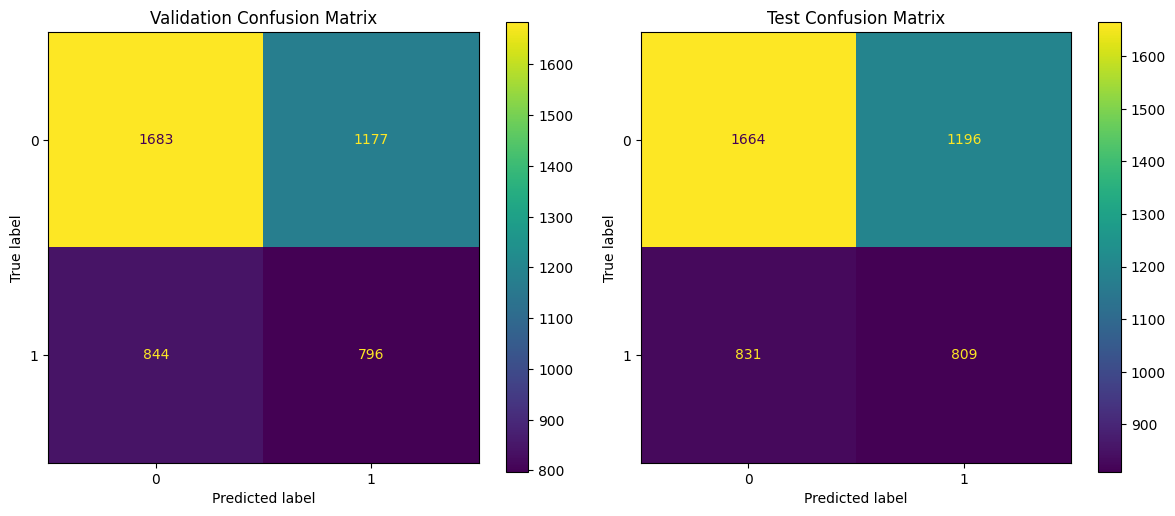

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("train.csv")

# Drop rows with missing target
df = df.dropna(subset=["song_popularity"])

# Separate features and target
X = df.drop(columns=["id", "song_popularity"])
y = df["song_popularity"]

# Impute missing values with median
X = X.fillna(X.median(numeric_only=True))

# One-hot encode categorical features
X = pd.get_dummies(X, columns=["key", "audio_mode", "time_signature"], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Define models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Train and evaluate models
best_model = None
best_auc = 0

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"{name} Validation AUC: {val_auc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = model

# Evaluate best model on test set
test_preds = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_preds)
print(f"\nBest Model: {type(best_model).__name__}")
print(f"Test AUC: {test_auc:.4f}")

# Confusion matrices
val_cm = confusion_matrix(y_val, best_model.predict(X_val))
test_cm = confusion_matrix(y_test, best_model.predict(X_test))

# Display confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(val_cm).plot(ax=axes[0], values_format='d')
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay(test_cm).plot(ax=axes[1], values_format='d')
axes[1].set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


song_popularity
0    0.6356
1    0.3644
Name: proportion, dtype: float64


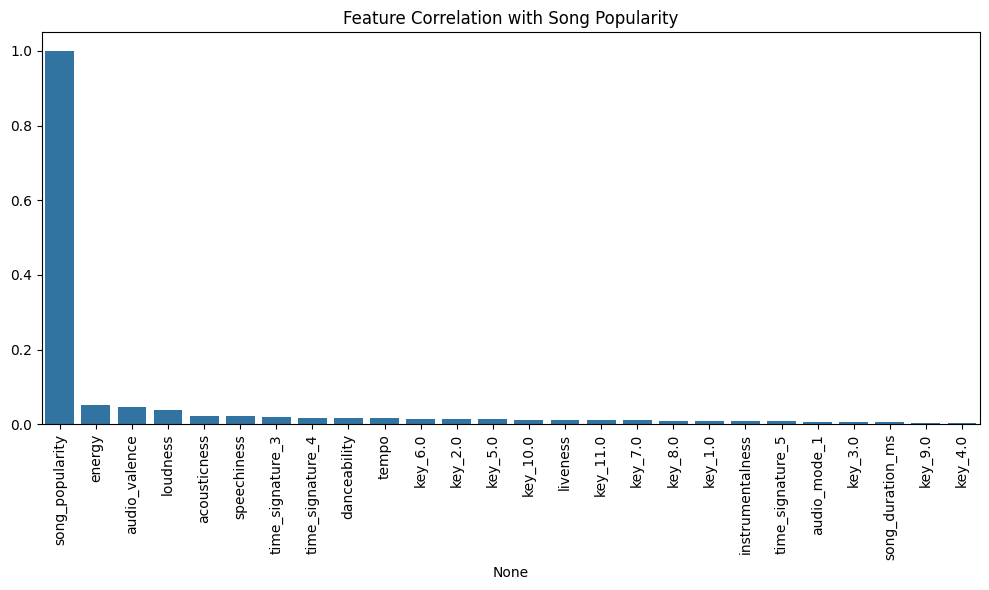

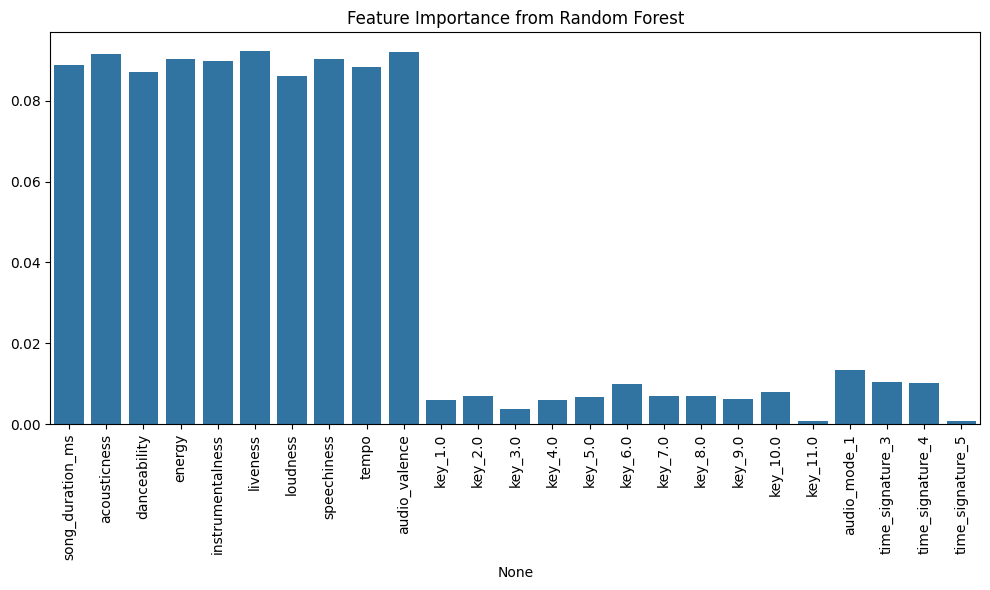

In [ ]:
print(y.value_counts(normalize=True))
print('='*70)
import seaborn as sns
import matplotlib.pyplot as plt

# Add target back to the feature set for correlation
df_corr = X.copy()
df_corr["song_popularity"] = y
# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot correlation with target
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_matrix["song_popularity"].abs().sort_values(ascending=False).index,
            y=corr_matrix["song_popularity"].abs().sort_values(ascending=False).values)
plt.xticks(rotation=90)
plt.title("Feature Correlation with Song Popularity")
plt.tight_layout()
plt.show()
print('='*70)
model = RandomForestClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()



GradientBoosting Best AUC: 0.5524
LightGBM Best AUC: 0.5589


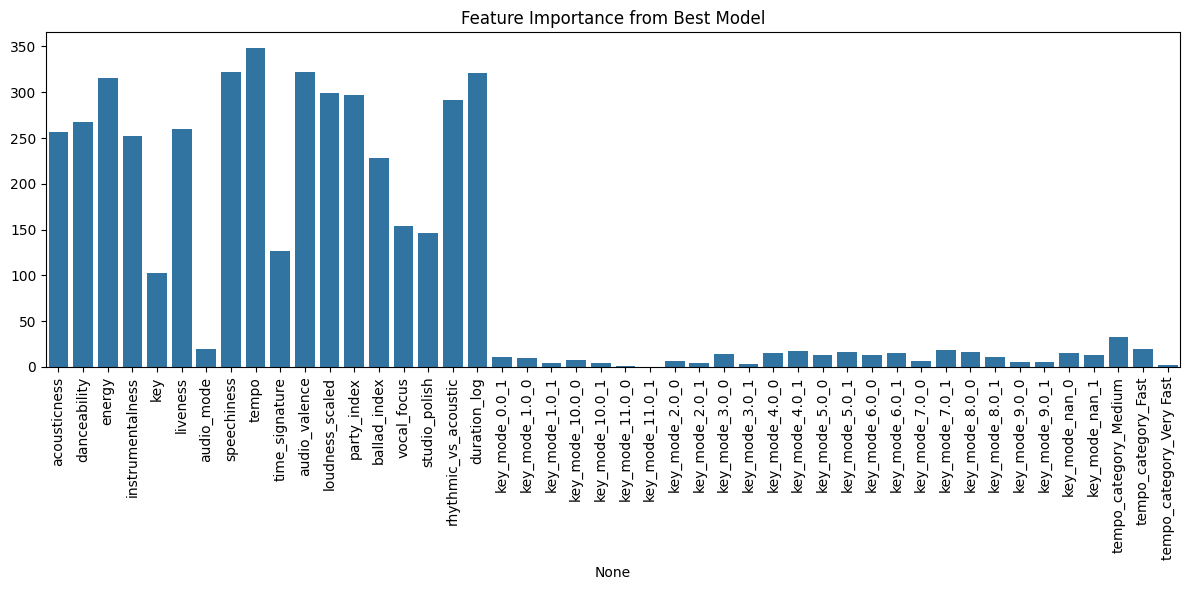

Stacked Ensemble Validation AUC: 0.5532
Stacked Ensemble Test AUC: 0.5531


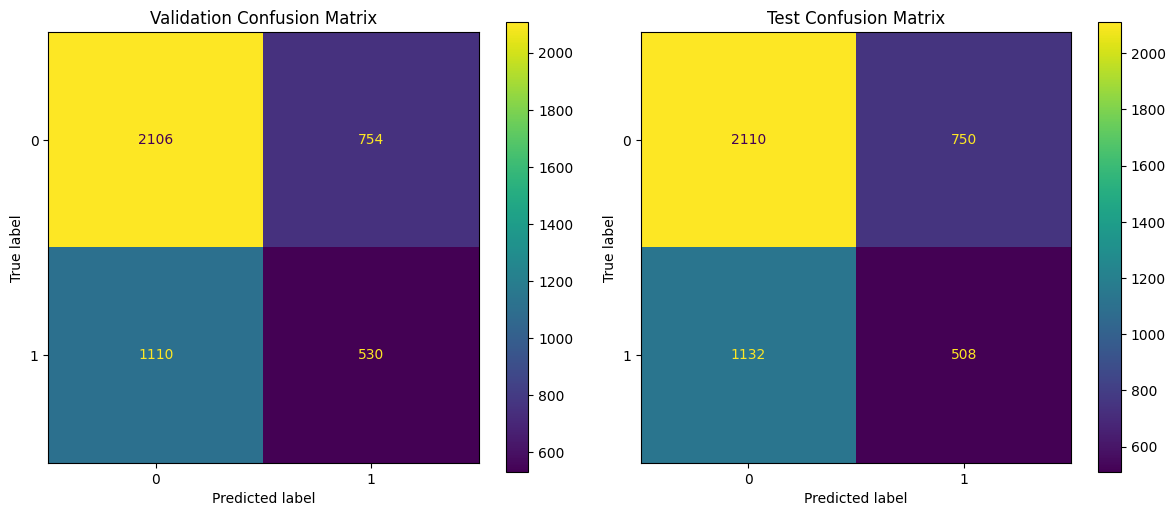

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

# Load and clean data
df = pd.read_csv("train.csv")
df = df.dropna(subset=["song_popularity"])
X = df.drop(columns=["id", "song_popularity"])
y = df["song_popularity"]

# Feature engineering
def engineer_features(df_in, df_ref=None):
    df_out = df_in.copy()
    df_out['key_mode'] = df_out['key'].astype(str) + '_' + df_out['audio_mode'].astype(str)
    df_out['tempo_category'] = pd.cut(df_out['tempo'], bins=[0, 90, 120, 150, 250],
                                      labels=['Slow', 'Medium', 'Fast', 'Very Fast'])
    if df_ref is None:
        df_ref = df_out
    df_out['loudness_scaled'] = (df_out['loudness'] - df_ref['loudness'].min()) / \
                                (df_ref['loudness'].max() - df_ref['loudness'].min())
    df_out['party_index'] = df_out['danceability'] * df_out['energy'] * df_out['loudness_scaled']
    df_out['ballad_index'] = df_out['acousticness'] / (df_out['energy'] + 1e-6)
    df_out['vocal_focus'] = 1 - df_out['instrumentalness']
    df_out['studio_polish'] = 1 - df_out['liveness']
    df_out['rhythmic_vs_acoustic'] = df_out['danceability'] - df_out['acousticness']
    df_out['duration_log'] = np.log1p(df_out['song_duration_ms'])
    df_out['key_mode'] = df_out['key_mode'].astype('category')
    df_out['tempo_category'] = df_out['tempo_category'].astype('category')
    df_out.drop(['loudness', 'song_duration_ms'], axis=1, inplace=True)
    return df_out

X_eng = engineer_features(X)
X_eng = X_eng.fillna(X_eng.median(numeric_only=True))
X_eng = pd.get_dummies(X_eng, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# SMOTE balancing
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, scoring='roc_auc', cv=3)
gb_grid.fit(X_train_bal, y_train_bal)
gb_auc = roc_auc_score(y_val, gb_grid.predict_proba(X_val)[:, 1])

lgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
lgb_grid = GridSearchCV(LGBMClassifier(random_state=42), lgb_params, scoring='roc_auc', cv=3)
lgb_grid.fit(X_train_bal, y_train_bal)
lgb_auc = roc_auc_score(y_val, lgb_grid.predict_proba(X_val)[:, 1])

print(f"GradientBoosting Best AUC: {gb_auc:.4f}")
print(f"LightGBM Best AUC: {lgb_auc:.4f}")

# Feature importance from best model
best_model = gb_grid.best_estimator_ if gb_auc > lgb_auc else lgb_grid.best_estimator_
importances = best_model.feature_importances_
features = X_eng.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance from Best Model")
plt.tight_layout()
plt.show()

# Stacked ensemble
base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', gb_grid.best_estimator_),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgb', lgb_grid.best_estimator_)
]
meta_learner = LogisticRegression()
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=3)
stacked_model.fit(X_train_bal, y_train_bal)

val_auc = roc_auc_score(y_val, stacked_model.predict_proba(X_val)[:, 1])
test_auc = roc_auc_score(y_test, stacked_model.predict_proba(X_test)[:, 1])
print(f"Stacked Ensemble Validation AUC: {val_auc:.4f}")
print(f"Stacked Ensemble Test AUC: {test_auc:.4f}")

# Confusion matrices
val_cm = confusion_matrix(y_val, stacked_model.predict(X_val))
test_cm = confusion_matrix(y_test, stacked_model.predict(X_test))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(val_cm).plot(ax=axes[0], values_format='d')
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay(test_cm).plot(ax=axes[1], values_format='d')
axes[1].set_title("Test Confusion Matrix")
plt.tight_layout()
plt.show()
